In [2]:
!pip install pillow numpy torch opencv-python matplotlib seaborn torchvision tqdm scikit-learn umap-learn huggingface-hub git-lfs transformers timm

In [3]:
import torch
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from huggingface_hub import hf_hub_url, cached_download
from torch.nn import MultiheadAttention
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn import MultiheadAttention

REPO_NAME = 'ppxscal/cv_project'
X_FILE = 'X_tensor.pt'
Y_FILE = 'y_tensor.pt'

# Get the URL for each file
x_url = hf_hub_url(REPO_NAME, X_FILE)
y_url = hf_hub_url(REPO_NAME, Y_FILE)

# Download the files and cache them locally
x_cache = cached_download(x_url)
y_cache = cached_download(y_url)

# Load the tensors from the cached files
X = torch.load(x_cache)
y = torch.load(y_cache)

/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [4]:
print(X.shape, y.shape)

torch.Size([8831, 128, 128]) torch.Size([8831])


In [5]:
import torch
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from huggingface_hub import hf_hub_url, cached_download

REPO_NAME = 'ppxscal/cv_project'
X_FILE = 'X_tensor.pt'
Y_FILE = 'y_tensor.pt'

# Get the URL for each file
x_url = hf_hub_url(REPO_NAME, X_FILE)
y_url = hf_hub_url(REPO_NAME, Y_FILE)

# Download the files and cache them locally
x_cache = cached_download(x_url)
y_cache = cached_download(y_url)

# Load the tensors from the cached files
X = torch.load(x_cache)
y = torch.load(y_cache)
#torch.Size([8831, 128, 128]) torch.Size([8831])

class_counts = y.bincount()
num_samples = y.size(0)
class_weights = 1. / class_counts

# Create a list of weights for each sample
sample_weights = class_weights[y]

# Set up the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# Create a dataset and a dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
# print(f'Corrupted images: {corrupted}')

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width*height)
        value = self.value_conv(x).view(batch_size, -1, width*height)

        attention = torch.bmm(query, key)
        attention = self.softmax(attention / (C**0.5))
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return out + x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.attention1 = SelfAttention(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.attention2 = SelfAttention(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.attention3 = SelfAttention(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.attention1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.attention2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.attention3(x)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Device configuration, optimizer, loss function, and training loop remain the same.
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # You can adjust this based on your specific needs

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders for both training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

# Starting the training and validation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):  # Use train_loader for training
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():  # No gradient updates during validation
        for images, labels in tqdm(val_loader):  # Use val_loader for validation
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}% \n')

  0%|          | 0/221 [00:07<?, ?it/s]


KeyboardInterrupt: 

8831 (8831, 4) (4,) 8831


/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


(8831, 2)


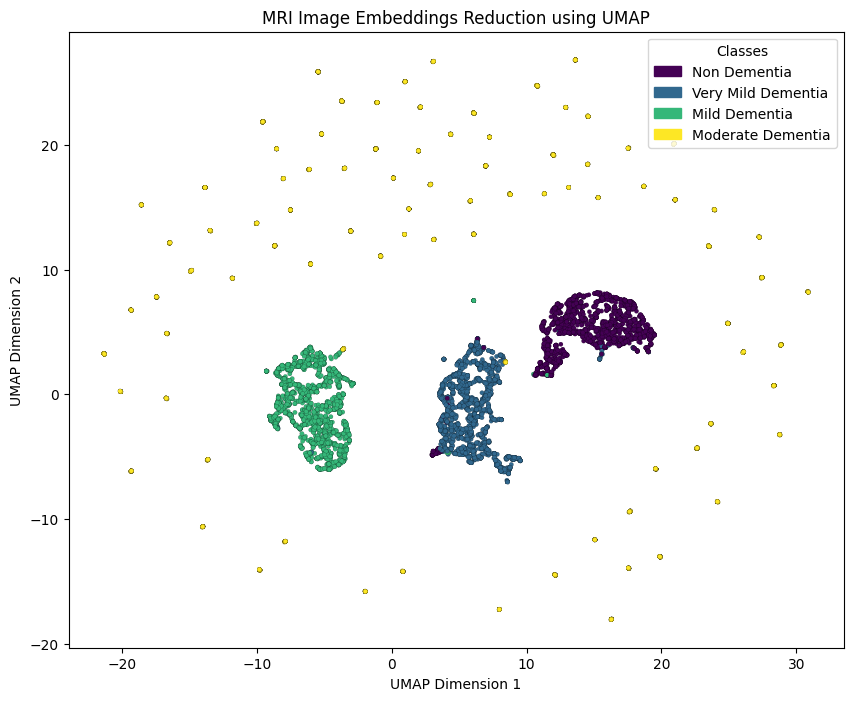

In [ ]:
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.unsqueeze(1).to(device)
        emb = model(images)
        # print(F.softmax(emb, dim=0))
        embeddings.append(emb.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.cm import plasma  # Import plasma colormap

labels_to_class = {
0: "Non Dementia",
1: "Very Mild Dementia",
2: "Mild Dementia",
3: "Moderate Dementia",
}
print(len(embeddings), embeddings.shape, embeddings[0].shape, len(labels_list))

# Perform UMAP reduction
reducer = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='hamming')
umap_embeddings = reducer.fit_transform(embeddings)
print(umap_embeddings.shape)
# umap_embeddings = umap_embeddings / np.linalg.norm(umap_embeddings, axis=1)
cmap = plt.cm.viridis

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels_list, cmap=cmap, s=10, edgecolor='black', linewidth=0.1)
# Create a legend
legend_handles = [mpatches.Patch(color=cmap(i / (len(labels_to_class) - 1)), label=labels_to_class[i]) for i in labels_to_class]
plt.legend(handles=legend_handles, title="Classes")

plt.title('MRI Image Embeddings Reduction using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()